In [1]:
import pandas as pd
import numpy as np
from modeling import cleaned_fr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

ML Lib:

In [2]:
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# _Predicting which Disorder Type_

# Experiment 1

Fitting some basic models and assessing their performance without any parameter fine-tunning.

In [3]:
# Models in experiment 1
models = {
            'BernoulliNB' : BernoulliNB(),
            'GaussianNB' : GaussianNB(),
            'DTr' : DecisionTreeClassifier(),
            'ExTrs': ExtraTreesClassifier(),
            'KNeigh' : KNeighborsClassifier(),
            'svc': SVC(probability=True),
            'xgb' : XGBClassifier(),
            'logistic' : LogisticRegression(),
            'MLP' : MLPClassifier()
        }

In [18]:
# Importing cleaned frame
df = cleaned_fr(avoid_systolic=True, insomnia_cat=2)

# Fit to sleep_apnea=0 vs insomnia=1
df = (df
        .assign(sleep_issue = df.sleep_issue - 1)
        .query("sleep_issue >= 0")
        .astype({'sleep_issue' :'uint8'})
        )

In [20]:
# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Select binary columns to avoid scaling below
binary_cols = X.select_dtypes('uint8').columns

# Remaining columns
non_binary_cols = [col for col in X.columns if col not in binary_cols]

# Times to repeat Kfold instance
rKF = RepeatedKFold(n_repeats=34, n_splits=3, random_state=23)

In [21]:
# Transformer that scales the non-binary columns and does nothing to the binary columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_folds, _names, _accuracy, _precision, _recall, _f1, _auc, _set_type = [], [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('preprocessor', preprocessor),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)

            # Proba for AUC
            y_proba = _local_pipe.predict_proba(X1)[:, 1]  # Probabilities for the positive class
            _auc.append( roc_auc_score(Y1, y_proba) )
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

In [22]:
# Saving in DataFrame
result_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1, 'auc':_auc} )

In [28]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'accuracy'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'], ascending=False)

set,train,test
model_name,,
MLP,0.945926,0.892985
logistic,0.911574,0.883443
xgb,0.968223,0.870616
GaussianNB,0.896081,0.867300
ExTrs,0.968697,0.864752
DTr,0.968697,0.862072
BernoulliNB,0.878093,0.860749
svc,0.933965,0.860187
KNeigh,0.910636,0.853366


In [29]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'accuracy'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'])

set,train,test
model_name,,
logistic,0.018482,0.037352
MLP,0.016519,0.040159
ExTrs,0.011554,0.043046
KNeigh,0.021330,0.043989
BernoulliNB,0.022443,0.045431
svc,0.018185,0.046015
DTr,0.011554,0.046787
xgb,0.011408,0.047619
GaussianNB,0.067631,0.076640


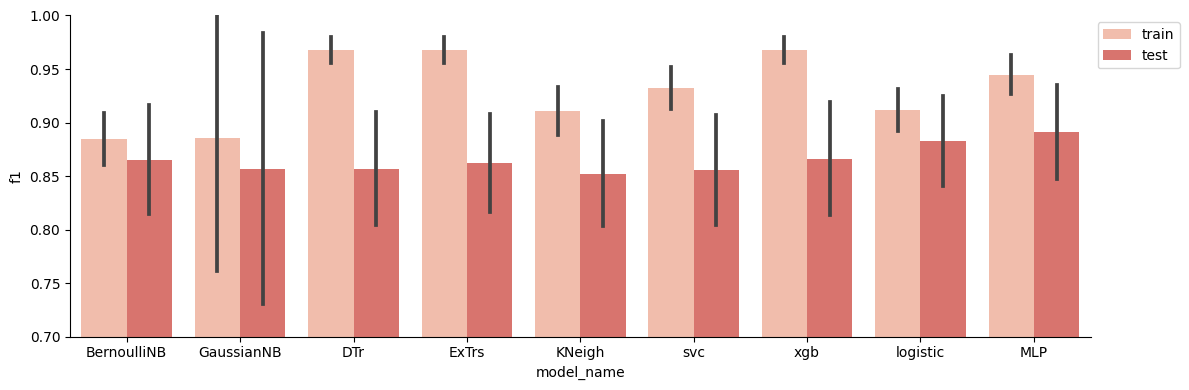

In [32]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result_df.filter(['fold_id', 'model_name', 'set'] + ["accuracy"]),
    x="model_name", y="accuracy", hue="set",
    palette="Reds", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.7, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('experiment1_recall_NoSys.png', dpi=200 )
plt.show()

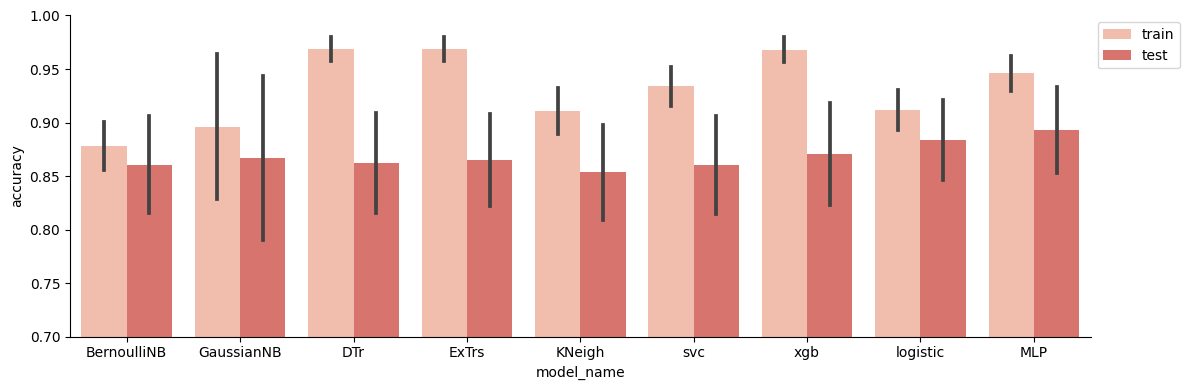

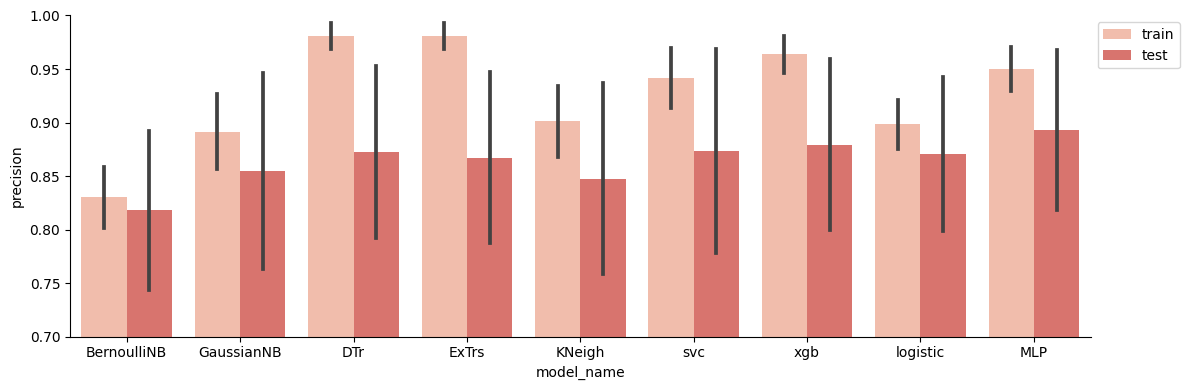

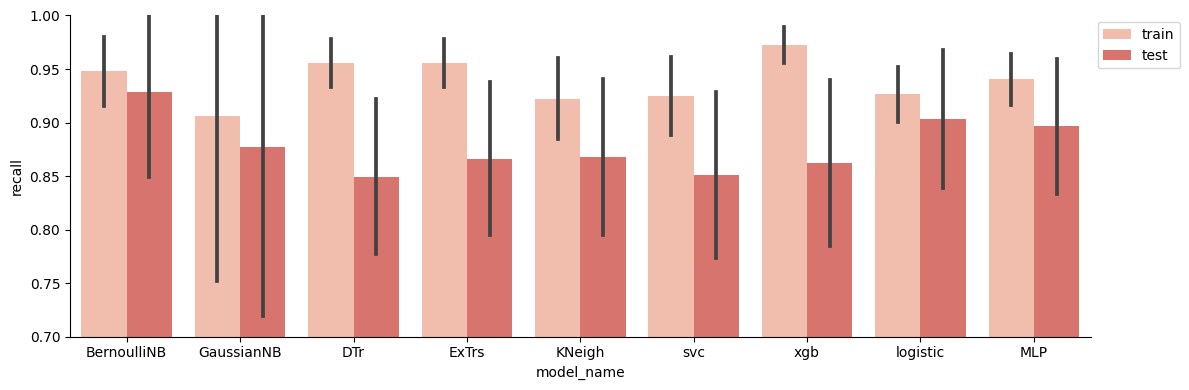

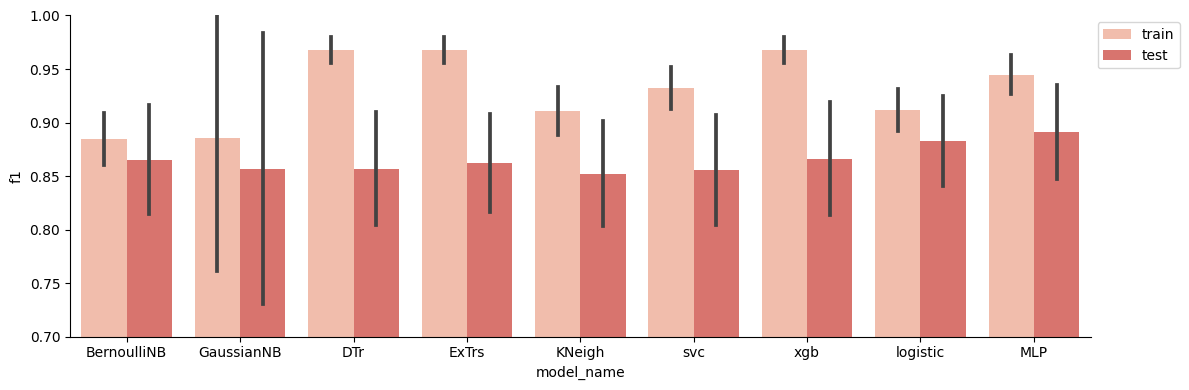

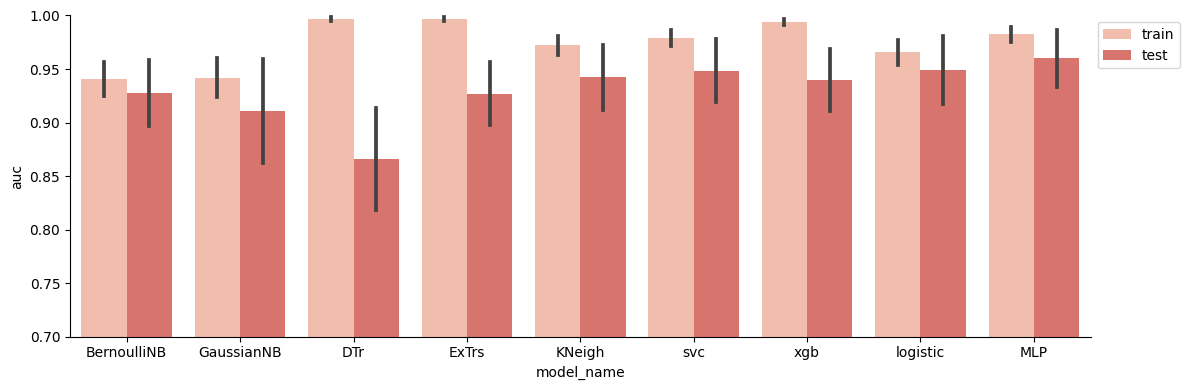

In [34]:
for metric in result_df.columns[3:]:

    fig, ax = plt.subplots(figsize=(12,4))

    sns.barplot(
        data = result_df.filter(['fold_id', 'model_name', 'set'] + [metric]),
        x="model_name", y=metric, hue="set",
        palette="Reds", alpha=.75, ax=ax, errorbar='sd'
    )

    sns.despine(top=True, right=True)

    # Set y-axis limits
    ax.set_ylim(0.7, 1)

    # Move legend outside of the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()  # Adjust layout so everything fits nicely
    plt.show()

For this approach is noticeable overfitting in all the metrics. Nevertheless, MLP and logistic regression seem the candidates to explore further

In [35]:
# Saving Result
result_df.to_csv('Data/SleepIssueTypeExperiment1.csv')

# MLP Parameter tunning

In [37]:
from sklearn.model_selection import GridSearchCV

In [40]:
# Model to tune
model = MLPClassifier()

# Recalling the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_search_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('MLP', model)
                    ])

# Parameters for grid search
param_grid = {
    'MLP__hidden_layer_sizes': [(200,), (200,100),(300,200,100), (200,100,50), (300,200,100)],
    'MLP__activation': ['logistic','tanh','relu'],
    'MLP__solver': ['lbfgs', 'adam'],
    'MLP__max_iter': [200,300,400],
    'MLP__early_stopping': [True], # Adding these last two parameters to make sure the loop doesn't get stuck unwantedly and shorten execution time
    'MLP__validation_fraction': [.25]
}

grid_search = GridSearchCV(_search_pipe, param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'MLP__activation': 'logistic', 'MLP__early_stopping': True, 'MLP__hidden_layer_sizes': (200,), 'MLP__max_iter': 200, 'MLP__solver': 'adam', 'MLP__validation_fraction': 0.25}
Best cross-validation score: 0.8839


In [43]:
# Getting the best parameters
mlp_parameters = {key[5:] : val for key, val in grid_search.best_params_.items()}

# Dropping unwanted parameters
mlp_parameters.pop('early_stopping')
mlp_parameters.pop('validation_fraction')

print("Selected Parameters:", mlp_parameters)

# Getting the best mlp parameters from the dictionary above
best_mlp_model = MLPClassifier( **mlp_parameters )

Selected Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (200,), 'max_iter': 200, 'solver': 'adam'}


# Logistic Regression Parameter tunning

In [45]:
# Model to tune
model = LogisticRegression()

# Recalling the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_search_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('Logistic', model)
                    ])

# Parameters for grid search
param_grid = {
    'Logistic__penalty' : ['l1', 'l2', 'elasticnet', None],
    'Logistic__solver' : ['lbfgs', 'liblinear'],
    'Logistic__max_iter' : [100,200,300,400,500],
}

grid_search = GridSearchCV(_search_pipe, param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation Recall: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'Logistic__max_iter': 100, 'Logistic__penalty': None, 'Logistic__solver': 'lbfgs'}
Best cross-validation Recall: 0.8774


Let's keep the default parameters since there's no improvement in recall.

In [48]:
best_logistic_model = LogisticRegression( **{key[10:] : val for key, val in grid_search.best_params_.items()} )

In [8]:
best_logistic_model = LogisticRegression( **{'max_iter': 100, 'penalty': None, 'solver': 'lbfgs'} )

# Final Experiment

Besides taking the best 3 classifiers. Let's also merge them into voting and stacking methods to try to improve recall

In [49]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [50]:
# Models in Final Experiment
models = {
    'best_logistic' : best_logistic_model,
    'bestMLP' : best_mlp_model
}

# Creating Stacking classifier
_stack = StackingClassifier( estimators=list(models.items()), final_estimator=LogisticRegression())

# Adding Votting
_soft = VotingClassifier(estimators=list(models.items()), voting='soft')
_hard = VotingClassifier(estimators=list(models.items()), voting='hard')

# Adding Keys to Dict
models['stacked'] = _stack
models['soft_vote'] = _soft
models['hard_vote'] = _hard

In [51]:
# Importing cleaned frame
df = cleaned_fr(avoid_systolic=True, insomnia_cat=2)

# Fit to sleep_apnea=0 vs insomnia=1
df = (df
        .assign(sleep_issue = df.sleep_issue - 1)
        .query("sleep_issue >= 0")
        .astype({'sleep_issue' :'uint8'})
        )

# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Times to repeat Kfold instance (Aumented repetitions)
rKF = RepeatedKFold(n_repeats=100, n_splits=3, random_state=23)

In [52]:
# Transformer that scales the non-binary columns and does nothing to the binary columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_folds, _names, _accuracy, _precision, _recall, _f1, _auc, _set_type = [], [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('preprocessor', preprocessor),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

In [53]:
# Saving in DataFrame
result2_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1} )

In [54]:
# Quick  look to the average performance
result2_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'accuracy'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'], ascending=False)

set,train,test
model_name,,
best_logistic,0.938096,0.903610
soft_vote,0.926900,0.894639
stacked,0.931741,0.893341
hard_vote,0.925742,0.891921
bestMLP,0.902386,0.881839


In [55]:
# Quick  look to the performance std
result2_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'accuracy'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'])

set,train,test
model_name,,
soft_vote,0.024574,0.035780
hard_vote,0.020444,0.036241
stacked,0.023252,0.036242
best_logistic,0.020845,0.036829
bestMLP,0.016848,0.039467


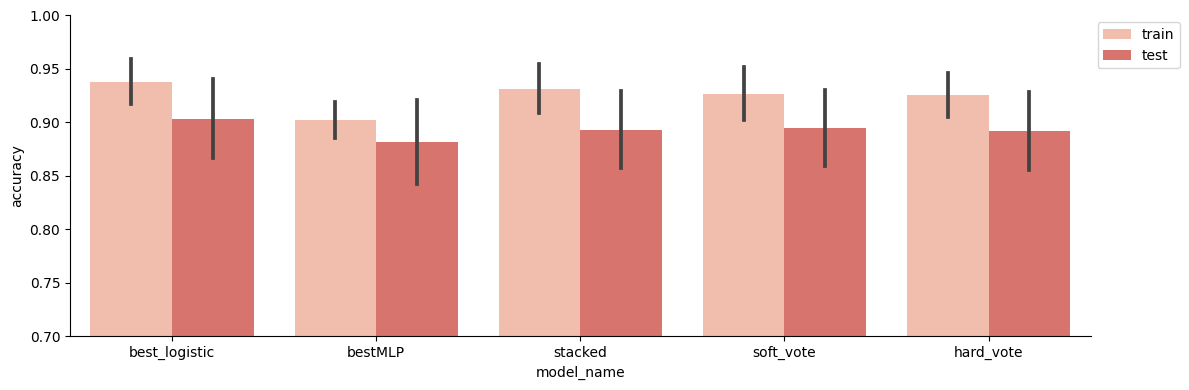

In [56]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result2_df.filter(['fold_id', 'model_name', 'set'] + ["accuracy"]),
    x="model_name", y="accuracy", hue="set",
    palette="Reds", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.7, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('SleepIssueTypeExperiment2_accuracy.png', dpi=200 )
plt.show()

In [57]:
# Save the results
result2_df.to_csv('Data/SleepIssueTypeFinalExperiment.csv')

# Save Best _"Sleep Issue Type"_ Model

Based on the results, we can see that logistic regression tends to have a higher performance, although there's a slight overfitting, this model is prefered for its simplicity specially when compared to the other algorithms. Therefore, lets save the logistic model parametrization to add in our app.

In [4]:
from modeling import train_and_save_model

In [9]:
train_and_save_model("SleepIssueType_ModelScaled", best_logistic_model, disorder_pipeline=True)